/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


              pfaf       segId isHill          area  \
27769    L0C2R4879  71027770.0      0  2.952612e+06   
27786    L0C2R4881  71027787.0      0  1.380575e+08   
27941  L0C2R489111  71027942.0      0  1.530590e+08   
27956  L0C2R489113  71027957.0      0  9.345949e+07   
27961   L0C2R48913  71027962.0      0  1.982458e+06   
...            ...         ...    ...           ...   
39147   L0C2R48722  71039148.0      0  3.342063e+07   
39170   L0C2R48762  71039171.0      0  3.593082e+07   
39195    L0C2R4884  71039196.0      0  5.216591e+07   
39249  L0C2R489414  71039250.0      0  2.795768e+07   
39265   L0C2R48984  71039266.0      0  1.136992e+08   

                                                geometry  max_length  length  \
27769  MULTIPOLYGON (((-11003818.034 5700194.287, -11...          13       9   
27786  MULTIPOLYGON (((-11027537.578 5702282.202, -11...          13       9   
27941  POLYGON ((-11030110.545 5710555.141, -11029386...          13      11   
27956  MULTIPOLYGON

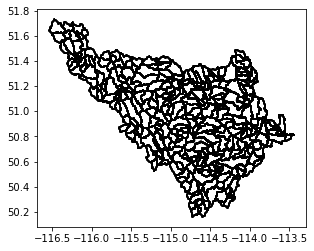

In [44]:
import geopandas as gpd
import simpledbf
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import time

# user specifies
# link to the file located here
# /home/shg096/projects/rpp-kshook/Model_Output/ClimateForcingData/output_MERIT_Hydro_basin_NA_EPSG6933
name_of_the_shp    = '/Users/shg096/Desktop/catEndoMERITpfaf_NA.shp' # shapefile with pfaf field
target_PFAF        = 'L0C2R48577' # the pfaf of the most sownstream
name_of_PFAF_field = 'pfaf' # name of pfaf field in shapefile
name_of_dir_save   = '../pfafsubset/'
fixed_buffer       = 7 # this should be adjusted
digit_buffer       = 7 # number of digit that is used to compare the upstream
# load the file
shp_org = gpd.read_file(name_of_the_shp)
######
shp = shp_org
shp = shp.dropna(subset=['pfaf']) # remove nans
shp ['max_length']   = shp.pfaf.str.len().max() # get the maximume length of pfaf
shp ['length']       = shp['pfaf'].str.len() # get of the length of each pfaf
shp ['0_str']        = '0' # create '0'
shp ['pfaf_long']    = shp ['pfaf'] + shp ['0_str'] * (shp ['max_length']-shp ['length']) # zero to the end
shp['pfaf_long_cut'] = shp['pfaf_long'].str[:fixed_buffer] # cut the upper part of the pfaf
shp = shp[shp['pfaf_long_cut'] == target_PFAF[:fixed_buffer]]
shp ['pfaf_digit'] = shp['pfaf_long'].str[digit_buffer:-1].astype(int)
shp = shp[shp['pfaf_digit'] >= shp[shp['pfaf']==target_PFAF].pfaf_digit.iloc[0]]
#######
shp = shp.to_crs("EPSG:4326")
shp.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2)
if not os.path.isdir(name_of_dir_save):
    os.mkdir(name_of_dir_save)
shp.to_file(name_of_dir_save+target_PFAF+'.shp')



In [45]:
# user specifies
# shapefile river here
# /home/shg096/projects/rpp-kshook/Model_Output/ClimateForcingData/MERIT_Hydro_river/rivEndoMERITpfaf_71.gpkg
name_of_river_shp = '/Users/shg096/Desktop/MERIT_Hydro/riv/\
riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
name_of_subset_shp = '../pfafsubset/L0C2R48577.shp' # shapefile subset from pervious cell

# read shapefile
shp_river = gpd.read_file(name_of_river_shp)
shp = gpd.read_file(name_of_subset_shp)
shp['COMID'] = shp['segId']
# no use for coastal hillslope as they dont have rivers
merged_pd = pd.merge(shp_river, shp, on='COMID')
# create the NTOPO dataframe
NTOPO = pd.DataFrame()
NTOPO['length']     = merged_pd['lengthkm'] * 1000
NTOPO['basin_area'] = merged_pd['area'] 
NTOPO['slope']      = merged_pd['slope']
NTOPO['hruid']      = merged_pd['COMID'] 
NTOPO['seg_hr_id']  = merged_pd['COMID'] 
NTOPO['seg_id']     = merged_pd['COMID'] 
NTOPO['tosegment']  = merged_pd['NextDownID']
# COMID ID of the most downstream
COMID_DOWN = 71033960 # the last COMID in the network topology
idx = NTOPO.loc[NTOPO['seg_id'] == COMID_DOWN].reset_index().index
NTOPO.tosegment.iloc[idx] = -9999

# for a simple case where seg and hru are identical nhru = nseg
name_of_nc      = 'network_topology_Bow.nc'
field_names     = [  'length','basin_area',   'slope','hruid','seg_hr_id','seg_id','tosegment']
var_names       = [  'length','basin_area',   'slope','hruid','seg_hr_id','seg_id','tosegment']
var_lng_names   = [  'length','basin_area',   'slope','hruid','seg_hr_id','seg_id','tosegment']
var_units       = [       'm',      'm**2',       '-',    '-',        '-',     '-',        '-']
var_types       = [      'f8',        'f8',      'f8',  'int',      'int',   'int',      'int']
var_Fill_values = ['-9999.99',  '-9999.99','-9999.99','-9999',    '-9999', '-9999',    '-9999']
name_of_nc      = 'Ntopo.nc'

# create the network topology file with parameters 
def nc_creation(NTOPO, name_of_nc, field_names, var_names,\
                var_lng_names, var_units, var_types,\
                var_Fill_values):
    # remove existing files
    if os.path.isfile(name_of_nc):
        os.remove(name_of_nc)
    # open the nc file to write
    ncid = nc4.Dataset(name_of_nc, "w", format="NETCDF4")
    # the dimension of the nc file variables is equal to the row of the shapefile
    dimid_N = ncid.createDimension('n',NTOPO.shape[0])
    dimid_Nchar = ncid.createDimension('nchar',4)
    # going through the field one by one and saving them in nc varibales with long name, units and variable type (int, etc)
    for i in np.arange(len(field_names)):
        # define the variable;
        varid = ncid.createVariable(var_names[i], var_types[i],('n',),\
                                    zlib=True, fill_value=var_Fill_values[i])
        # Attributes
        varid.long_name      = var_lng_names[i]
        varid.unit           = var_units[i]
        # Write data
        varid[:]             = NTOPO[field_names[i]]
    # define the variable PFAF
    varid = ncid.createVariable('PFAF','S1',('n','nchar',)) #assuming all the fields are floats
    # Attributes
    varid.long_name      = 'PFAF Order'
    varid.unit           = '-'
    # preparing the data
    data = np.full(NTOPO.shape[0], 'test', 'S4')
    data = nc4.stringtochar(data)
    varid[:,:]=data
    ncid.Conventions = 'CF-1.6'
    ncid.License     = 'The data were written by Shervan Gharari. They are under GPL.'
    ncid.history     = 'Created ' + time.ctime(time.time())
    ncid.source      = 'Written by test script of utilities (https://github.com/ShervanGharari/utility-codes).'
    ncid.close()
    
nc_creation(NTOPO, name_of_nc,field_names, var_names,\
            var_lng_names, var_units, var_types,\
            var_Fill_values)


           length    basin_area     slope     hruid  seg_hr_id    seg_id  \
0     2040.825048  2.952612e+06  0.000978  71027770   71027770  71027770   
1    33309.245280  1.380575e+08  0.002191  71027787   71027787  71027787   
2    28145.109601  1.530590e+08  0.001798  71027942   71027942  71027942   
3    20589.551321  9.345949e+07  0.001508  71027957   71027957  71027957   
4     2160.028961  1.982458e+06  0.002403  71027962   71027962  71027962   
..            ...           ...       ...       ...        ...       ...   
336    990.667071  3.342063e+07  0.000202  71039148   71039148  71039148   
337   4296.244983  3.593082e+07  0.007620  71039171   71039171  71039171   
338  14752.598490  5.216591e+07  0.008957  71039196   71039196  71039196   
339   2518.299361  2.795768e+07  0.032782  71039250   71039250  71039250   
340  11978.910948  1.136992e+08  0.005844  71039266   71039266  71039266   

     tosegment  
0        -9999  
1     71027770  
2     71027770  
3     71027942  
4 

/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Code to do intersect and remap file

In [ ]:
# intersect code from CANDEX

In [ ]:
def remap_nc(data_frame):
    """
    @ author:                  Shervan Gharari
    @ Github:                  https://github.com/ShervanGharari/candex
    @ author's email id:       sh.gharari@gmail.com
    @ license:                 GNU_GPLv3
    This function takes in a single array of data with an ID and it lat and lon value and save it as nc file
    Arguments
    ---------
    dataframe that comes from intersection of hydrological model units (e.g. grid) and subbasins
    """
    # pass the dataframe as shp_int
    shp_int = data_frame
    # get the frequency of the dataframe for S_1_ID colomn which is the routing subbasins
    shp_int['freq'] = shp_int.groupby('S_1_ID')['S_1_ID'].transform('count')
    shp_int = shp_int.sort_values(by=['S_1_ID'])
    print(shp_int.columns)
    ID_of_GRUs_with_repeat = np.array(shp_int['S_2_ID']); # this is <vname_qhruid> and is saved as GRUs dimension m
    Weight_of_GRUs_in_subbasins = np.array(shp_int['Weight']); # this is <vname_weight> and is saved as weight dimensioned m
    #ID_of_GRUs_with_repeat.sort()
    shp_int_drop = shp_int.drop_duplicates('S_1_ID') # collapsing the S_1_ID
    ID_of_subbasins = np.array(shp_int_drop['S_1_ID']) # getting the unique ID of subbains <vname_hruid_in_remap> as subbasinid
    freq_of_subbasins = np.array(shp_int_drop['freq']) # getting the unique frequency of subbasins <vname_num_qhru> as freq
    
    # open the nc file to write
    ncid = nc4.Dataset('Remap.nc', "w", format="NETCDF4")
    
    # the dimension of the nc file variables is equal to the row of the shapefile
    dimid_M = ncid.createDimension('m',shp_int.shape[0])
    dimid_L = ncid.createDimension('l',shp_int_drop.shape[0])
    
    # ID of subasins
    varid = ncid.createVariable('subbasinid','int',('l',),fill_value=-9999) #
    # Attributes
    varid.long_name      = 'ID of subbasins'
    varid.unit           = '-'
    # Write data
    varid[:] = ID_of_subbasins
    
    # freqency of GRU participation in each subasins
    varid = ncid.createVariable('frequency','int',('l',),fill_value=-9999) #
    # Attributes
    varid.long_name      = 'frequency of the GRUs participating in each subbasins'
    varid.unit           = '-'
    # Write data
    varid[:] = freq_of_subbasins
    
    # the ID of GRUs participating in the subasins
    varid = ncid.createVariable('GRUid','int',('m',),fill_value=-9999) #
    # Attributes
    varid.long_name      = 'id of GRUs contributing to each subbasin'
    varid.unit           = '-'
    # Write data
    varid[:] = ID_of_GRUs_with_repeat
    
    # the weight of each GRUs participating in the subasins
    varid = ncid.createVariable('GRUweight','f8',('m',),fill_value=-9999) #
    # Attributes
    varid.long_name      = 'the weight of each GRUs contributing to each subbasin'
    varid.unit           = '-'
    # Write data
    varid[:] = Weight_of_GRUs_in_subbasins
    
    
    ncid.Conventions = 'CF-1.6'
    ncid.License     = 'The data were written by Shervan Gharari. They are under GPL.'
    ncid.history     = 'Created ' + time.ctime(time.time())
    ncid.source      = 'Written by test script of utilities (https://github.com/ShervanGharari/utility-codes).'
    ncid.close()

### end of remap code

In [8]:
# preparation of the forcing data from the remapped data
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

# specifying candex objects
# name of the case; the temporary, remapping and remapped file names include case name
cndx.case_name                = 'WRF_Isabelle'
# temporary path that the candex generated GIS files and remapped file will be saved
cndx.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
cndx.sink_shp                 = '/Users/shg096/Desktop/L0C2R48577.shp'
cndx.sink_shp_ID              = 'segId'
# name of netCDF file(s); multiple files can be specified with *
cndx.source_nc                = '/Users/shg096/Desktop/merged_2000-10-01.nc'
# name of variables from source netCDF file(s) to be remapped
cndx.var_names                = ['I_RAINNC','LWDNB','P','PREC_ACC_C','PREC_ACC_NC',\
                                'Q2','RAINC','RAINNC','SWDNB','T2','U10','V10']
# name of variable longitude in source netCDF files
cndx.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
cndx.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
cndx.var_time                 = 'time'
# location where the remapped netCDF file will be saved
cndx.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
cndx.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
cndx.fill_value_list          = ['-9999.00']
# if exists and uncommented candex will use this remapping info and skip GIS tasks
#cndx.remap_csv                = '../temporary/WRF_Isabelle_remapping.csv'

# execute candex
cndx.run_candex()


no  author name is provide and the author name is changes to (author name)!
candex is given multiple varibales to be remapped but only on format and fill valuecandex repeat the format and fill value for all the variables in output files
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that the field for ID is provided in sink/target shapefile
candex detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
candex detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t
it seems everything is OK with the sink/target shapefile; added to candex object sink_shp_gpd
candex will save standard shapefile for candex claculation as:
../temporary/WRF_Isabelle_sink_shapefile.shp


/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:209: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lat_t']  = shp.centroid.y # centroid lat from target
/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:216: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lon_t']  = shp.centroid.x # centroid lon from target


candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['time', 'y', 'x']
candex detects that the longitude varibales has dimensions of:
['y', 'x']
candex detects that the latitude varibales has dimensions of:
['y', 'x']
candex detects case 2 - rotated lat/lon
candex is creating the shapefile from the netCDF file and saving it here:
../temporary/WRF_Isabelle_source_shapefile.shp
-120.75228881835938 46.88842582702637 -108.13016128540039 53.99990463256836
candex decides the netCDF file has longtitude values of -180 to 180; creating the extended


/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:731: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1']  = shp_1.area
/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:743: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2']  = shp_2.area
/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:831: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/opt/anaconda3/lib/python3.8/site-packages/candex/candex.py:835: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry 

Remapping /Users/shg096/Desktop/merged_2000-10-01.nc to ../output/WRF_Isabelle_remapped_2000-10-01-00-00-00.nc
Started at date and time 2021-03-03 16:21:33.404684
Ended   at date and time 2021-03-03 16:21:34.583531


In [47]:
# create the SUMMA input forcing files
import glob
import xarray as xr
import netCDF4 as nc4
import os

# import the name of the remapped files
names = sorted(glob.glob('../output/WRF_Isabelle_remapped*.nc'))

# create the time step varibale for SUMMA
if os.path.isfile('test.nc'):
    os.remove('test.nc')
with nc4.Dataset('test.nc', "w", format="NETCDF4") as ncid: # creating the NetCDF file
        # Varible data_step
        data_step_varid = ncid.createVariable('data_step', 'f8', (), fill_value=-999)
        # Attributes
        data_step_varid.long_name = 'data step length in seconds'
        data_step_varid.units = 's'
        # value allocation
        data_step_varid[:] = 3600 # seconds for an hour; should be changed for longer time period
ds_time = xr.open_dataset('test.nc')

#
for name in names:
    ds = xr.open_dataset(name) # rename
    dictionaty = {'PREC_ACC_NC':'pptrate',
                 'T2'          :'airtemp',
                 'SWDNB'       :'SWRadAtm',
                 'LWDNB'       :'LWRadAtm',
                 'Q2'          :'spechum',
                 'P'           :'airpres'}
    ds            = ds.rename(name_dict=dictionaty) # rename
    ds['windspd'] = ds['U10']
    ds.windspd[:] = (ds.U10[:]**2+ds.V10[:]**2)**0.5 # from direction to total wind speed
    ds.pptrate[:] = ds.pptrate[:] / 3600 # mm/hour to kg/m2/s
    ds            = ds.drop(['I_RAINNC','PREC_ACC_C','RAINC','RAINNC','U10','V10']) # drop non necessary varibales
    ds            = xr.merge([ds,ds_time]) # add time
    if os.path.isfile(name+'SUMMA'):
        os.remove(name+'SUMMA')
    ds.to_netcdf(name+'SUMMA')# save the data
    
os.remove('test.nc')
